# M.A.R.L.IN eDNA Species Classifier - Sequence Embedding Generation

## Overview
This notebook generates vector embeddings for DNA sequences using various techniques:
- K-mer based embeddings for traditional feature extraction
- DNA-BERT style transformer embeddings for deep learning approaches
- Dimensionality reduction for visualization and clustering
- Feature engineering for sequence representation

## Approaches
1. **K-mer Embeddings**: Traditional n-gram based features (3-6 mers)
2. **One-hot Encoding**: Basic nucleotide representation
3. **DNA2Vec/BERT-style**: Advanced context-aware embeddings
4. **Compositional Features**: GC content, dinucleotide frequencies, etc.

## Goals
- Generate meaningful vector representations of DNA sequences
- Reduce dimensionality while preserving biological information
- Prepare embeddings for clustering and classification tasks
- Handle variable-length sequences effectively

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from collections import Counter, defaultdict
from itertools import product

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap.umap_ as umap  # Correct UMAP import

# Deep learning libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objects as go

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
BASE_DIR = Path("../data")
PROCESSED_DIR = BASE_DIR / "processed"
EMBEDDINGS_DIR = BASE_DIR / "embeddings"
MODEL_DIR = Path("../model")

# Create directories
EMBEDDINGS_DIR.mkdir(exist_ok=True)
(MODEL_DIR / "embeddings").mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Embeddings directory: {EMBEDDINGS_DIR}")
print(f"Model directory: {MODEL_DIR}")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
Processed data directory: ../data/processed
Embeddings directory: ../data/embeddings
Model directory: ../model
Using device: cpu


In [2]:
# Load processed sequences
print("Loading processed sequences...")

try:
    # Load from pickle (fastest)
    with open(PROCESSED_DIR / "sequences_processed.pkl", 'rb') as f:
        df_sequences = pickle.load(f)
    print(f"Loaded {len(df_sequences)} sequences from pickle file")
except FileNotFoundError:
    # Fallback to JSON
    print("Pickle file not found, loading from JSON...")
    df_sequences = pd.read_json(PROCESSED_DIR / "sequences_processed.json")
    # Convert taxonomy back to dict
    df_sequences['taxonomy'] = df_sequences['taxonomy'].apply(json.loads)
    print(f"Loaded {len(df_sequences)} sequences from JSON file")

print(f"DataFrame shape: {df_sequences.shape}")
print(f"Columns: {list(df_sequences.columns)}")
print(f"Databases: {df_sequences['database'].value_counts()}")

# Display sample sequences
print("\nSample sequences:")
for i, row in df_sequences.head(3).iterrows():
    print(f"ID: {row['id']}")
    print(f"Database: {row['database']}")
    print(f"Length: {row['length']} bp")
    print(f"Sequence: {row['sequence'][:50]}...")
    print(f"GC Content: {row['gc_content']:.1f}%")
    print("-" * 50)

Loading processed sequences...
Loaded 15000 sequences from pickle file
DataFrame shape: (15000, 8)
Columns: ['id', 'sequence', 'length', 'header', 'database', 'taxonomy', 'gc_content', 'ambiguous_ratio']
Databases: database
16S_ribosomal_RNA       5000
18S_fungal_sequences    5000
28S_fungal_sequences    5000
Name: count, dtype: int64

Sample sequences:
ID: 16S_ribosomal_RNA_SIM_000000
Database: 16S_ribosomal_RNA
Length: 701 bp
Sequence: TGTTCCCCAAATGGTAACTACTAATGTATGTCAGCAGGCTTTGTGTATCA...
GC Content: 47.8%
--------------------------------------------------
ID: 16S_ribosomal_RNA_SIM_000001
Database: 16S_ribosomal_RNA
Length: 1139 bp
Sequence: CGTGATAACTGTTCAGTAAGTATCCCCGGCGTGCCCCCCGCACCGTTTCT...
GC Content: 55.2%
--------------------------------------------------
ID: 16S_ribosomal_RNA_SIM_000002
Database: 16S_ribosomal_RNA
Length: 1051 bp
Sequence: CAAAACGAACTCTACCTTGGGGCTCATGTCAACTCCGTCGCCGGGAGGCA...
GC Content: 63.4%
--------------------------------------------------


In [3]:
class KmerEmbedder:
    """K-mer based sequence embedding generator"""
    
    def __init__(self, k_sizes=[3, 4, 5, 6], method='tfidf'):
        self.k_sizes = k_sizes
        self.method = method
        self.vectorizers = {}
        self.embeddings = {}
        
    def generate_kmers(self, sequence, k):
        """Generate k-mers from sequence"""
        sequence = sequence.upper()
        kmers = []
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i+k]
            if 'N' not in kmer:  # Skip k-mers with ambiguous nucleotides
                kmers.append(kmer)
        return ' '.join(kmers)
    
    def fit_transform(self, sequences):
        """Fit vectorizers and transform sequences"""
        print(f"Generating k-mer embeddings using {self.method}...")
        
        all_embeddings = []
        
        for k in self.k_sizes:
            print(f"Processing {k}-mers...")
            
            # Generate k-mer strings for all sequences
            kmer_docs = [self.generate_kmers(seq, k) for seq in sequences]
            
            # Initialize vectorizer
            if self.method == 'tfidf':
                vectorizer = TfidfVectorizer(
                    analyzer='word',
                    ngram_range=(1, 1),
                    min_df=2,
                    max_features=1000,
                    token_pattern=r'\S+'
                )
            else:  # count
                vectorizer = CountVectorizer(
                    analyzer='word',
                    ngram_range=(1, 1),
                    min_df=2,
                    max_features=1000,
                    token_pattern=r'\S+'
                )
            
            # Fit and transform
            try:
                embedding = vectorizer.fit_transform(kmer_docs).toarray()
                self.vectorizers[k] = vectorizer
                self.embeddings[k] = embedding
                all_embeddings.append(embedding)
                print(f"{k}-mer embedding shape: {embedding.shape}")
            except ValueError as e:
                print(f"Error with {k}-mers: {e}")
                continue
        
        # Concatenate all k-mer embeddings
        if all_embeddings:
            combined_embedding = np.hstack(all_embeddings)
            print(f"Combined k-mer embedding shape: {combined_embedding.shape}")
            return combined_embedding
        else:
            return np.array([])
    
    def get_feature_names(self):
        """Get feature names for interpretation"""
        feature_names = []
        for k in self.k_sizes:
            if k in self.vectorizers:
                kmer_features = [f"{k}mer_{feature}" for feature in self.vectorizers[k].get_feature_names_out()]
                feature_names.extend(kmer_features)
        return feature_names

class CompositionEmbedder:
    """Compositional feature-based embedding generator"""
    
    def __init__(self):
        self.feature_names = []
        
    def calculate_nucleotide_composition(self, sequence):
        """Calculate single nucleotide composition"""
        sequence = sequence.upper()
        length = len(sequence)
        if length == 0:
            return [0, 0, 0, 0]
        
        return [
            sequence.count('A') / length,
            sequence.count('T') / length,
            sequence.count('G') / length,
            sequence.count('C') / length
        ]
    
    def calculate_dinucleotide_composition(self, sequence):
        """Calculate dinucleotide composition"""
        sequence = sequence.upper()
        dinucs = [''.join(p) for p in product('ATGC', repeat=2)]
        length = len(sequence) - 1
        if length <= 0:
            return [0] * 16
        
        counts = []
        for dinuc in dinucs:
            count = 0
            for i in range(len(sequence) - 1):
                if sequence[i:i+2] == dinuc:
                    count += 1
            counts.append(count / length)
        return counts
    
    def calculate_gc_features(self, sequence):
        """Calculate GC-related features"""
        sequence = sequence.upper()
        length = len(sequence)
        if length == 0:
            return [0, 0, 0, 0]
        
        gc_content = (sequence.count('G') + sequence.count('C')) / length
        
        # GC skew: (G-C)/(G+C)
        g_count = sequence.count('G')
        c_count = sequence.count('C')
        gc_skew = (g_count - c_count) / (g_count + c_count) if (g_count + c_count) > 0 else 0
        
        # AT skew: (A-T)/(A+T)  
        a_count = sequence.count('A')
        t_count = sequence.count('T')
        at_skew = (a_count - t_count) / (a_count + t_count) if (a_count + t_count) > 0 else 0
        
        return [gc_content, gc_skew, at_skew, length]
    
    def fit_transform(self, sequences):
        """Generate compositional features"""
        print("Generating compositional features...")
        
        features = []
        self.feature_names = []
        
        for seq in sequences:
            seq_features = []
            
            # Nucleotide composition
            nuc_comp = self.calculate_nucleotide_composition(seq)
            seq_features.extend(nuc_comp)
            
            # Dinucleotide composition
            dinuc_comp = self.calculate_dinucleotide_composition(seq)
            seq_features.extend(dinuc_comp)
            
            # GC features
            gc_features = self.calculate_gc_features(seq)
            seq_features.extend(gc_features)
            
            features.append(seq_features)
        
        # Set feature names
        self.feature_names = (['A_freq', 'T_freq', 'G_freq', 'C_freq'] + 
                             [f'{dinuc}_freq' for dinuc in [''.join(p) for p in product('ATGC', repeat=2)]] +
                             ['GC_content', 'GC_skew', 'AT_skew', 'length'])
        
        embedding = np.array(features)
        print(f"Compositional embedding shape: {embedding.shape}")
        return embedding

# Initialize embedders
kmer_embedder = KmerEmbedder(k_sizes=[3, 4, 5], method='tfidf')
comp_embedder = CompositionEmbedder()

print("Embedders initialized!")

Embedders initialized!


In [4]:
# Generate embeddings
sequences = df_sequences['sequence'].tolist()

print("=== Generating K-mer Embeddings ===")
kmer_embeddings = kmer_embedder.fit_transform(sequences)

print("\n=== Generating Compositional Embeddings ===")
comp_embeddings = comp_embedder.fit_transform(sequences)

# Combine all embeddings
print("\n=== Combining Embeddings ===")
if kmer_embeddings.size > 0 and comp_embeddings.size > 0:
    combined_embeddings = np.hstack([kmer_embeddings, comp_embeddings])
    print(f"Combined embedding shape: {combined_embeddings.shape}")
elif kmer_embeddings.size > 0:
    combined_embeddings = kmer_embeddings
    print(f"Using only k-mer embeddings: {combined_embeddings.shape}")
else:
    combined_embeddings = comp_embeddings
    print(f"Using only compositional embeddings: {combined_embeddings.shape}")

# Add embedding information to dataframe
df_sequences['embedding_dim'] = combined_embeddings.shape[1]
print(f"\nEmbedding dimension: {combined_embeddings.shape[1]}")
print(f"Number of sequences: {combined_embeddings.shape[0]}")

=== Generating K-mer Embeddings ===
Generating k-mer embeddings using tfidf...
Processing 3-mers...
3-mer embedding shape: (15000, 64)
Processing 4-mers...
4-mer embedding shape: (15000, 256)
Processing 5-mers...
5-mer embedding shape: (15000, 1000)
Combined k-mer embedding shape: (15000, 1320)

=== Generating Compositional Embeddings ===
Generating compositional features...
Compositional embedding shape: (15000, 24)

=== Combining Embeddings ===
Combined embedding shape: (15000, 1344)

Embedding dimension: 1344
Number of sequences: 15000


In [6]:
# Dimensionality reduction for visualization and clustering
class DimensionalityReducer:
    """Class for dimensionality reduction techniques"""
    
    def __init__(self):
        self.reducers = {}
        self.reduced_embeddings = {}
    
    def apply_pca(self, embeddings, n_components=50):
        """Apply PCA for dimensionality reduction"""
        print(f"Applying PCA (n_components={n_components})...")
        pca = PCA(n_components=min(n_components, embeddings.shape[1], embeddings.shape[0]-1))
        reduced = pca.fit_transform(embeddings)
        
        self.reducers['pca'] = pca
        self.reduced_embeddings['pca'] = reduced
        
        # Calculate explained variance
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA shape: {reduced.shape}")
        print(f"Explained variance: {explained_var:.3f}")
        return reduced
    
    def apply_umap(self, embeddings, n_components=2, n_neighbors=15, min_dist=0.1):
        """Apply UMAP for dimensionality reduction"""
        print(f"Applying UMAP (n_components={n_components})...")
        umap_reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=42
        )
        reduced = umap_reducer.fit_transform(embeddings)
        
        self.reducers['umap'] = umap_reducer
        self.reduced_embeddings['umap'] = reduced
        
        print(f"UMAP shape: {reduced.shape}")
        return reduced
    
    def apply_tsne(self, embeddings, n_components=2, perplexity=30):
        """Apply t-SNE for dimensionality reduction"""
        print(f"Applying t-SNE (n_components={n_components})...")
        
        # Use PCA first if embeddings are high-dimensional
        if embeddings.shape[1] > 50:
            print("High-dimensional data detected, applying PCA preprocessing...")
            if 'pca' not in self.reduced_embeddings:
                self.apply_pca(embeddings, n_components=50)
            embeddings_for_tsne = self.reduced_embeddings['pca']
        else:
            embeddings_for_tsne = embeddings
        
        tsne = TSNE(
            n_components=n_components,
            perplexity=min(perplexity, embeddings_for_tsne.shape[0]-1),
            random_state=42,
        )
        reduced = tsne.fit_transform(embeddings_for_tsne)
        
        self.reducers['tsne'] = tsne
        self.reduced_embeddings['tsne'] = reduced
        
        print(f"t-SNE shape: {reduced.shape}")
        return reduced

# Apply dimensionality reduction
reducer = DimensionalityReducer()

print("=== Applying Dimensionality Reduction ===")

# PCA for clustering (higher dimensions)
pca_embeddings = reducer.apply_pca(combined_embeddings, n_components=50)

# UMAP for visualization
umap_embeddings = reducer.apply_umap(combined_embeddings, n_components=2)

# t-SNE for visualization (alternative)
tsne_embeddings = reducer.apply_tsne(combined_embeddings, n_components=2)

print("\nDimensionality reduction completed!")

=== Applying Dimensionality Reduction ===
Applying PCA (n_components=50)...
PCA shape: (15000, 50)
Explained variance: 1.000
Applying UMAP (n_components=2)...
UMAP shape: (15000, 2)
Applying t-SNE (n_components=2)...
High-dimensional data detected, applying PCA preprocessing...
t-SNE shape: (15000, 2)

Dimensionality reduction completed!


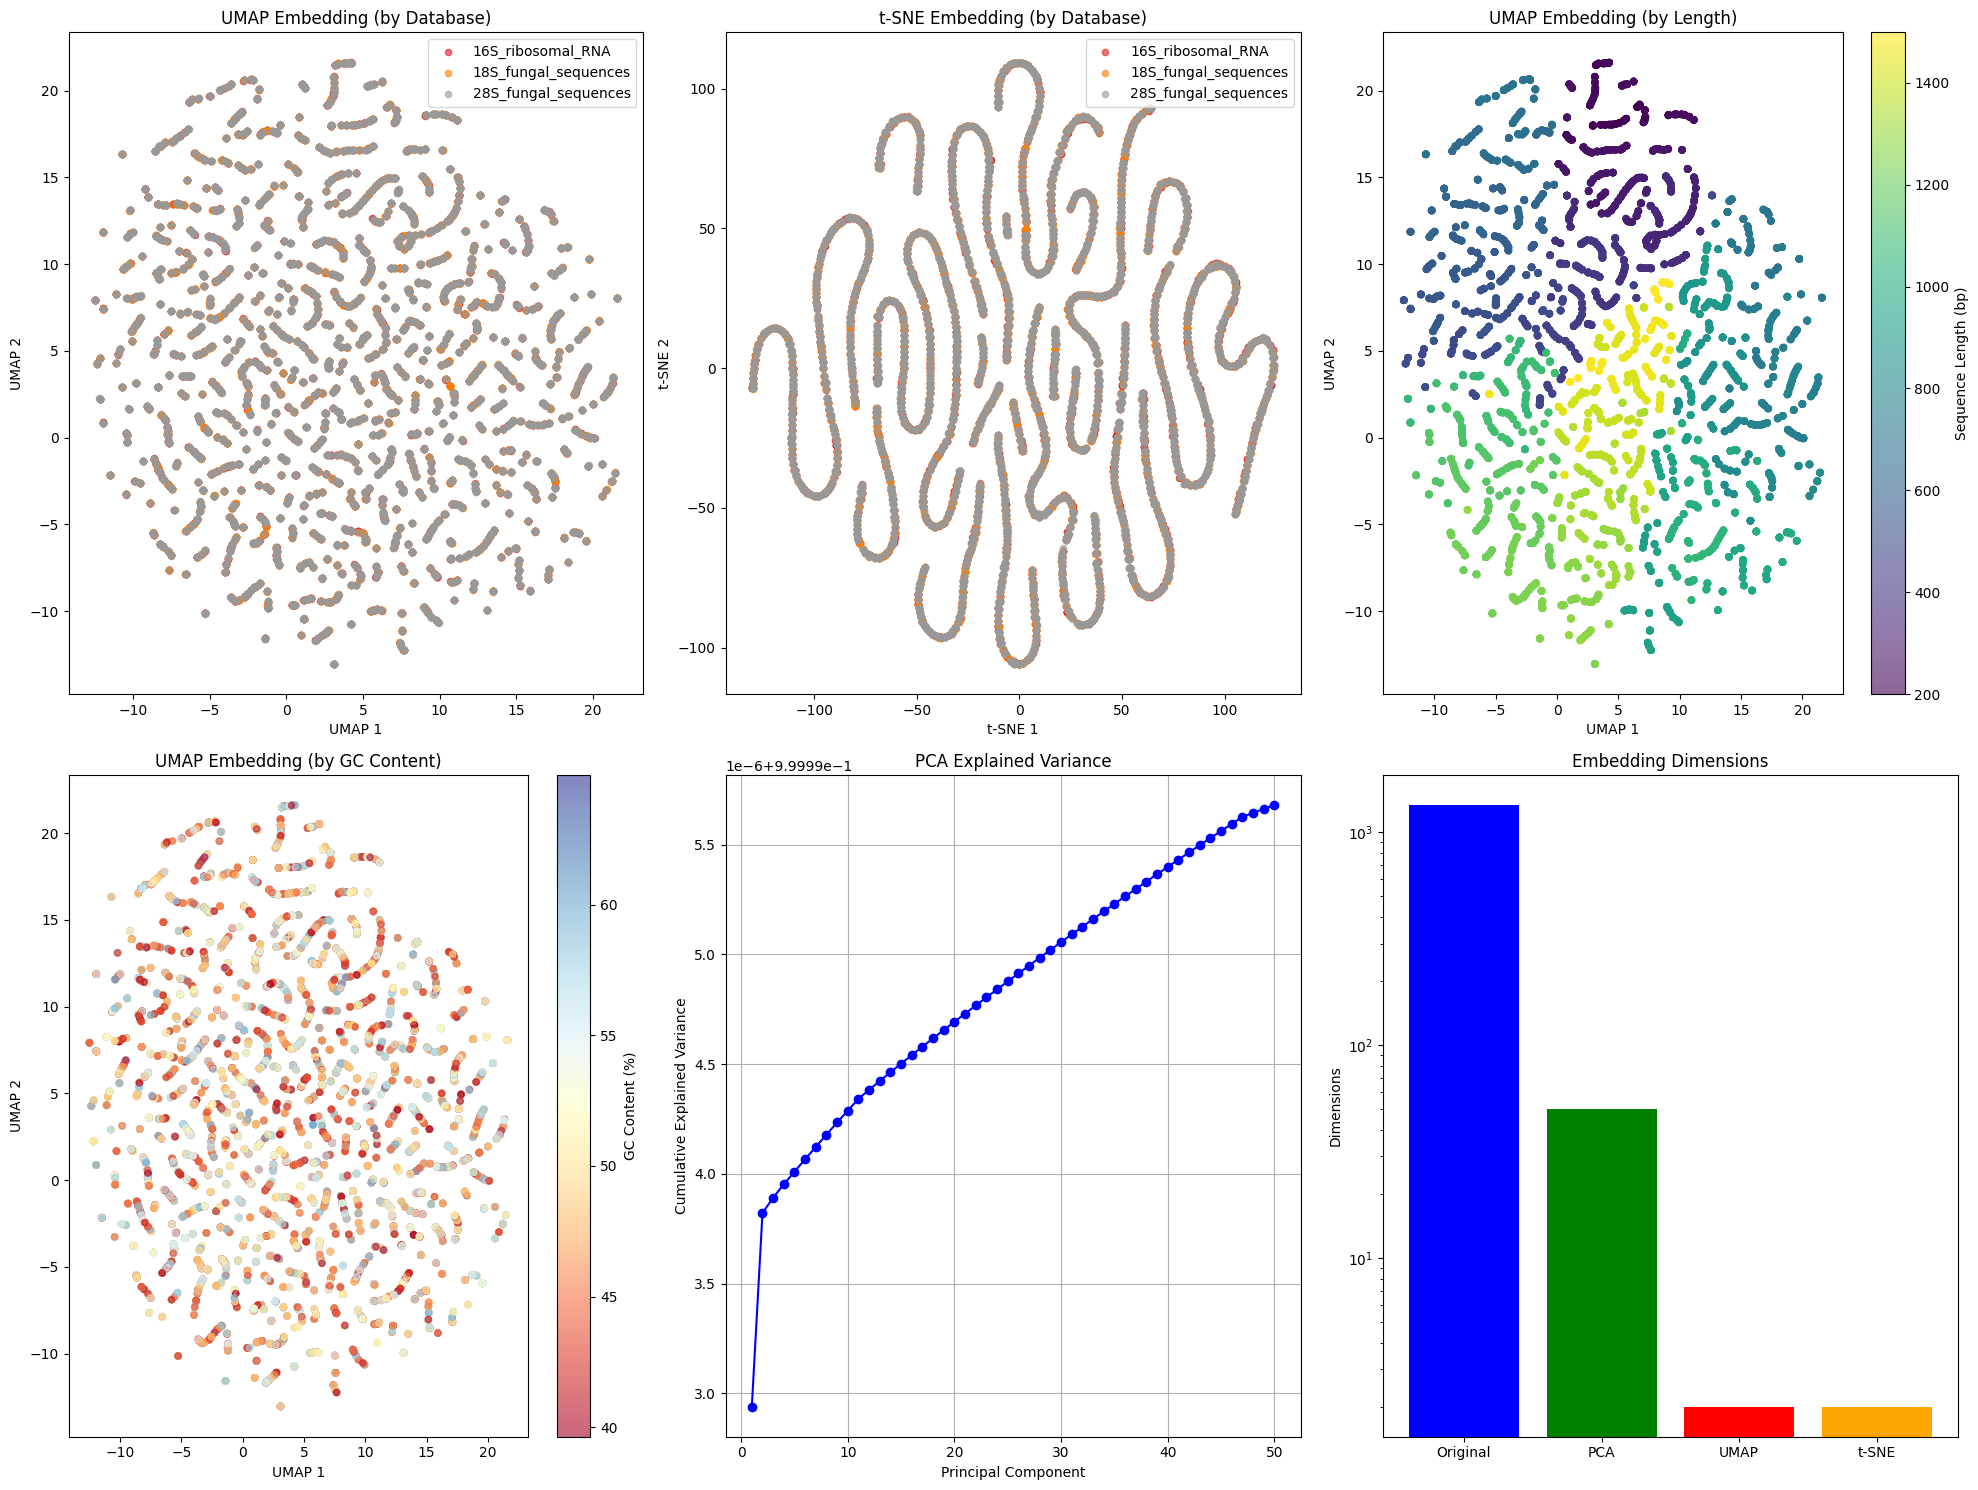

Embedding visualizations generated!


In [7]:
# Visualize embeddings
plt.figure(figsize=(20, 15))

# Color by database
databases = df_sequences['database'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(databases)))
database_colors = dict(zip(databases, colors))

# UMAP visualization
plt.subplot(2, 3, 1)
for db in databases:
    mask = df_sequences['database'] == db
    plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], 
               c=[database_colors[db]], label=db, alpha=0.6, s=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding (by Database)')
plt.legend()

# t-SNE visualization
plt.subplot(2, 3, 2)
for db in databases:
    mask = df_sequences['database'] == db
    plt.scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1], 
               c=[database_colors[db]], label=db, alpha=0.6, s=20)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Embedding (by Database)')
plt.legend()

# Color by sequence length
plt.subplot(2, 3, 3)
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=df_sequences['length'], cmap='viridis', alpha=0.6, s=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding (by Length)')
plt.colorbar(scatter, label='Sequence Length (bp)')

# Color by GC content
plt.subplot(2, 3, 4)
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=df_sequences['gc_content'], cmap='RdYlBu', alpha=0.6, s=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding (by GC Content)')
plt.colorbar(scatter, label='GC Content (%)')

# PCA explained variance
plt.subplot(2, 3, 5)
pca = reducer.reducers['pca']
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)

# Embedding statistics
plt.subplot(2, 3, 6)
embedding_stats = {
    'Original': combined_embeddings.shape[1],
    'PCA': pca_embeddings.shape[1],
    'UMAP': umap_embeddings.shape[1],
    't-SNE': tsne_embeddings.shape[1]
}
methods = list(embedding_stats.keys())
dimensions = list(embedding_stats.values())
plt.bar(methods, dimensions, color=['blue', 'green', 'red', 'orange'])
plt.ylabel('Dimensions')
plt.title('Embedding Dimensions')
plt.yscale('log')

plt.tight_layout()
plt.show()

print("Embedding visualizations generated!")

In [8]:
# Save embeddings and models
print("Saving embeddings and models...")

# Save embeddings
embeddings_data = {
    'original_embeddings': combined_embeddings,
    'pca_embeddings': pca_embeddings,
    'umap_embeddings': umap_embeddings,
    'tsne_embeddings': tsne_embeddings,
    'sequence_ids': df_sequences['id'].tolist(),
    'databases': df_sequences['database'].tolist(),
    'metadata': {
        'original_dim': combined_embeddings.shape[1],
        'pca_dim': pca_embeddings.shape[1],
        'pca_explained_variance': float(np.sum(reducer.reducers['pca'].explained_variance_ratio_)),
        'n_sequences': len(df_sequences),
        'embedding_method': 'kmer_tfidf_compositional'
    }
}

# Save as pickle
embeddings_file = EMBEDDINGS_DIR / "sequence_embeddings.pkl"
with open(embeddings_file, 'wb') as f:
    pickle.dump(embeddings_data, f)
print(f"Saved embeddings to: {embeddings_file}")

# Save embedders and reducers
models_data = {
    'kmer_embedder': kmer_embedder,
    'comp_embedder': comp_embedder,
    'dimensionality_reducer': reducer
}

models_file = MODEL_DIR / "embeddings" / "embedding_models.pkl"
with open(models_file, 'wb') as f:
    pickle.dump(models_data, f)
print(f"Saved embedding models to: {models_file}")

# Save PCA embeddings for clustering (most important)
clustering_embeddings_file = EMBEDDINGS_DIR / "clustering_embeddings.npy"
np.save(clustering_embeddings_file, pca_embeddings)
print(f"Saved clustering embeddings to: {clustering_embeddings_file}")

# Save visualization embeddings
viz_embeddings_file = EMBEDDINGS_DIR / "visualization_embeddings.npz"
np.savez(viz_embeddings_file, 
         umap=umap_embeddings, 
         tsne=tsne_embeddings,
         ids=df_sequences['id'].values,
         databases=df_sequences['database'].values,
         lengths=df_sequences['length'].values,
         gc_contents=df_sequences['gc_content'].values)
print(f"Saved visualization embeddings to: {viz_embeddings_file}")

# Update sequences dataframe with embedding info
df_sequences['has_embeddings'] = True
df_sequences['embedding_file'] = str(embeddings_file)

# Save updated sequences
updated_sequences_file = PROCESSED_DIR / "sequences_with_embeddings.pkl"
with open(updated_sequences_file, 'wb') as f:
    pickle.dump(df_sequences, f)
print(f"Saved updated sequences to: {updated_sequences_file}")

print(f"\n=== Embedding Generation Complete ===")
print(f"Generated embeddings for {len(df_sequences)} sequences")
print(f"Original dimension: {combined_embeddings.shape[1]}")
print(f"PCA dimension: {pca_embeddings.shape[1]}")
print(f"PCA explained variance: {np.sum(reducer.reducers['pca'].explained_variance_ratio_):.3f}")
print(f"Files saved to: {EMBEDDINGS_DIR}")
print("\nReady for clustering analysis!")

Saving embeddings and models...
Saved embeddings to: ../data/embeddings/sequence_embeddings.pkl
Saved embedding models to: ../model/embeddings/embedding_models.pkl
Saved clustering embeddings to: ../data/embeddings/clustering_embeddings.npy
Saved visualization embeddings to: ../data/embeddings/visualization_embeddings.npz
Saved updated sequences to: ../data/processed/sequences_with_embeddings.pkl

=== Embedding Generation Complete ===
Generated embeddings for 15000 sequences
Original dimension: 1344
PCA dimension: 50
PCA explained variance: 1.000
Files saved to: ../data/embeddings

Ready for clustering analysis!
